<a href="https://colab.research.google.com/github/Priyadharshinni/Musical_instrument_identification/blob/master/instrument.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install tensorflow==2.0



     |████████████████████████████████| 86.3MB 67kB/s 
     |████████████████████████████████| 3.8MB 40.5MB/s 
     |████████████████████████████████| 450kB 43.5MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=39ff99d59d67b15f729666e64204782a293962698851d5c4d26dbece79bb2d69
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.10.0rc0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installation: tensorboard 2.2.1
    Uninstalling tensorboard-2.2.1:
      Successfully uninstalled tensorboard-2.2.1
  Found existing installation: tensorflow-estimator 2.2.0
    Uninstalling tensorflow-estimator-2.2.0:
      Successfully uninstalled tensorflow-estimator-2.2.0
  Found existing installation

In [0]:
# Imports

#General
import numpy as np
import pickle
import itertools

# System
import os, fnmatch

# Visualization
import seaborn #visualization library, must be imported before all other plotting libraries
import matplotlib.pyplot as plt
from IPython.core.display import HTML, display, Image

from pandas.testing import assert_frame_equal
import pandas

# Machine Learning
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import recall_score, precision_score, accuracy_score
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from sklearn.metrics import classification_report

# Deep Learning
from keras import backend as K
from keras.layers import Input, Dense
from keras.models import Model, Sequential
from keras.optimizers import SGD
from keras.callbacks import History
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import plot_model

# Random Seed
import random
import tensorflow
tensorflow.random.set_seed(1)
from numpy.random import seed
             #seed(1)
             #random.set_seed(1)
# Audio
import librosa.display, librosa

# Configurations
path='sample'

In [0]:
# Get files in data path

files = []
for root, dirnames, filenames in os.walk(path):
    for filename in fnmatch.filter(filenames, '*.mp3'):
        files.append(os.path.join(root, filename))

print("found %d audio files in %s"%(len(files),path))

found 30 audio files in sample


In [0]:
filename="inst_labels.pl"
# Load labels
with open(filename, "rb") as f:
    labels = pickle.load( open( filename, "rb" ) )

In [0]:
# Encode Labels
labelencoder = LabelEncoder()
labelencoder.fit(labels)
print(len(labelencoder.classes_), "classes:", ", ".join(list(labelencoder.classes_)))
classes_num = labelencoder.transform(labels)

6 classes: cello, flute, oboe, sax, trumpet, viola


In [0]:
print('Labels:', labels[:3])
print('Encoded Classes: ', classes_num[0:3])

Labels: ['oboe', 'oboe', 'oboe']
Encoded Classes:  [2 2 2]


In [0]:
# Machine Learning Parameters
testset_size = 0.25 #Percentage of data for Testing



filename="mfcc_feature_vectors.pl"
# Load mfcc features from saved file
with open(filename, "rb") as f:
    scaled_feature_vectors = pickle.load( open( filename, "rb" ) )

In [0]:
# Create Train and Test Set
splitter = StratifiedShuffleSplit(n_splits=1, test_size=testset_size, random_state=0)
splits = splitter.split(scaled_feature_vectors, classes_num)
for train_index, test_index in splits:
    train_set = scaled_feature_vectors[train_index]
    test_set = scaled_feature_vectors[test_index]
    train_classes = classes_num[train_index]
    test_classes = classes_num[test_index]

In [0]:
# Check Set Shapes
print("train_set shape:",train_set.shape)
print("test_set shape:",test_set.shape)
print("train_classes shape:",train_classes.shape)
print("test_classes shape:",test_classes.shape)

train_set shape: (450, 13)
test_set shape: (150, 13)
train_classes shape: (450,)
test_classes shape: (150,)


In [0]:
# DNN
# Use Keras Backend Type
train_set_d=train_set.astype(K.floatx())
test_set_d=test_set.astype(K.floatx())

In [0]:
# One Hot encode
onehot_encoder = OneHotEncoder(sparse=False, categories='auto')
integer_encoded_train_classes =  train_classes.reshape(len( train_classes), 1)
onehot_encoded_train_classes = onehot_encoder.fit_transform(integer_encoded_train_classes,1)
integer_encoded_test_classes =  test_classes.reshape(len( test_classes),1)
onehot_encoded_test_classes = onehot_encoder.fit_transform(integer_encoded_test_classes,1)

In [0]:

print('Integer Encoded:', integer_encoded_train_classes[:3] )
print('One-hot Encoded: ', onehot_encoded_train_classes[:3] )

Integer Encoded: [[0]
 [2]
 [1]]
One-hot Encoded:  [[1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]]


In [0]:
# Check Set Shapes
print("train_set shape:",train_set_d.shape)
print("test_set shape:",test_set_d.shape)
print("train_classes shape:",onehot_encoded_train_classes.shape)
print("test_classes shape:",onehot_encoded_test_classes.shape)

train_set shape: (450, 13)
test_set shape: (150, 13)
train_classes shape: (450, 6)
test_classes shape: (150, 6)


In [0]:
# Reshape Sets for Keras
train_set_d=train_set.reshape(train_set_d.shape[0],1,train_set_d.shape[1])
test_set_d=test_set.reshape(test_set_d.shape[0],1,test_set_d.shape[1])
train_classes_d_hot=onehot_encoded_train_classes.reshape(onehot_encoded_train_classes.shape[0],1,
                                                         onehot_encoded_train_classes.shape[1])
test_classes_d_hot=onehot_encoded_test_classes.reshape(onehot_encoded_test_classes.shape[0],1,
                                                       onehot_encoded_test_classes.shape[1])

In [0]:
# Check Set Shapes
print("train_set shape:",train_set_d.shape)
print("test_set shape:",train_set_d.shape)
print("train_classes shape:",train_classes_d_hot.shape)
print("test_classes shape:",test_classes_d_hot.shape)

train_set shape: (450, 1, 13)
test_set shape: (450, 1, 13)
train_classes shape: (450, 1, 6)
test_classes shape: (150, 1, 6)


In [0]:
model_input = Input(shape=(1,train_set.shape[1]))
fc1 = Dense(12, activation="relu")(model_input)
fc2 = Dense(10, activation="relu")(fc1)
fc3 = Dense(8, activation="relu")(fc2)
fc4 = Dense(6, activation="relu")(fc2)
n=onehot_encoded_train_classes.shape[1]
out = Dense(n, activation="softmax")(fc4)
model_d = Model(inputs=[model_input], outputs=[out])
model_d.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1, 13)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1, 12)             168       
_________________________________________________________________
dense_2 (Dense)              (None, 1, 10)             130       
_________________________________________________________________
dense_4 (Dense)              (None, 1, 6)              66        
_________________________________________________________________
dense_5 (Dense)              (None, 1, 6)              42        
Total params: 406
Trainable params: 406
Non-trainable params: 0
_________________________________________________________________


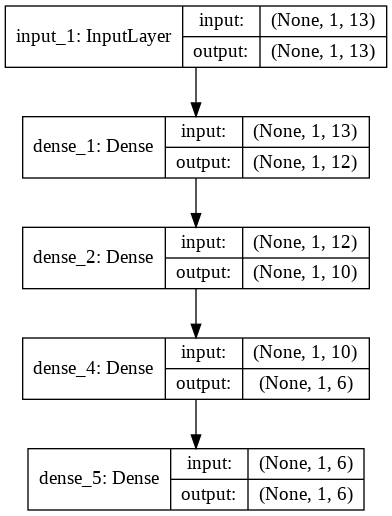

In [0]:
plot_model(model_d, to_file='model_d.png', show_shapes=True)
Image('model_d.png')

In [0]:
# Compile Model
model_d.compile(loss      = 'categorical_crossentropy',
              optimizer = SGD(lr=0.05),
              metrics   =['accuracy'])

In [0]:
# Deep Learning Parameters
batch_size = 5 # Number of samples per gradient update.
epochs = 200    # An epoch is an iteration over the entire x and y data provided.

# Train Model
hist = model_d.fit(train_set_d, train_classes_d_hot, verbose=1, 
                    batch_size=batch_size, epochs=epochs, validation_data=(test_set_d,test_classes_d_hot))

Train on 450 samples, validate on 150 samples
Epoch 1/200
450/450 [==============================] - 1s 1ms/step - loss: 1.6629 - accuracy: 0.3200 - val_loss: 1.4905 - val_accuracy: 0.3400
Epoch 2/200
450/450 [==============================] - 0s 309us/step - loss: 1.3301 - accuracy: 0.4822 - val_loss: 1.1899 - val_accuracy: 0.5200
Epoch 3/200
450/450 [==============================] - 0s 305us/step - loss: 1.0655 - accuracy: 0.6044 - val_loss: 0.9545 - val_accuracy: 0.6933
Epoch 4/200
450/450 [==============================] - 0s 302us/step - loss: 0.8375 - accuracy: 0.7378 - val_loss: 0.7854 - val_accuracy: 0.7400
Epoch 5/200
450/450 [==============================] - 0s 303us/step - loss: 0.6579 - accuracy: 0.8222 - val_loss: 0.5696 - val_accuracy: 0.8733
Epoch 6/200
450/450 [==============================] - 0s 308us/step - loss: 0.5151 - accuracy: 0.8711 - val_loss: 0.4983 - val_accuracy: 0.8933
Epoch 7/200
450/450 [==============================] - 0s 311us/step - loss: 0.3846 - 

KeyError: ignored

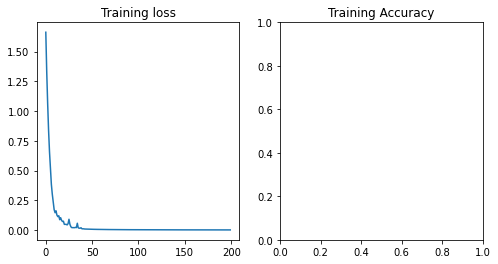

In [0]:
# Plot Training Loss and Training Accuracy
plt.figure(figsize=(8,4))
plt.subplot(1, 2, 1)
plt.title("Training loss")
plt.plot(range(epochs),hist.history["loss"])

plt.subplot(1, 2, 2)
plt.title("Training Accuracy")
plt.plot(range(epochs),hist.history["acc"])

plt.tight_layout()

In [0]:
# Predict
predictions = model_d.predict(test_set_d)
predictions_round=predictions.round().astype('int')
predictions_int=np.argmax(predictions_round,axis=2)
predictions_labels=labelencoder.inverse_transform(np.ravel(predictions_int))

In [0]:
print("Recall: ", recall_score(test_classes, predictions_int,average=None))

# Precision - The precision is intuitively the ability of the classifier not to label as positive a sample that is negatives
print("Precision: ", precision_score(test_classes, predictions_int,average=None))

# F1-Score - The F1 score can be interpreted as a weighted average of the precision and recall,
print("F1-Score: ", f1_score(test_classes, predictions_int, average=None))

# Accuracy - the number of correctly classified samples
print("Accuracy: ", accuracy_score(test_classes, predictions_int,normalize=False))
print("Number of samples:",test_classes.shape[0])

Recall:  [0.92 1.   0.96 1.   0.88 0.96]
Precision:  [0.92       1.         1.         0.96153846 0.91666667 0.92307692]
F1-Score:  [0.92       1.         0.97959184 0.98039216 0.89795918 0.94117647]
Accuracy:  143
Number of samples: 150


In [0]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(test_classes, predictions_int)
np.set_printoptions(precision=2)

In [0]:
# Function to Plot Confusion Matrix
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    """
    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

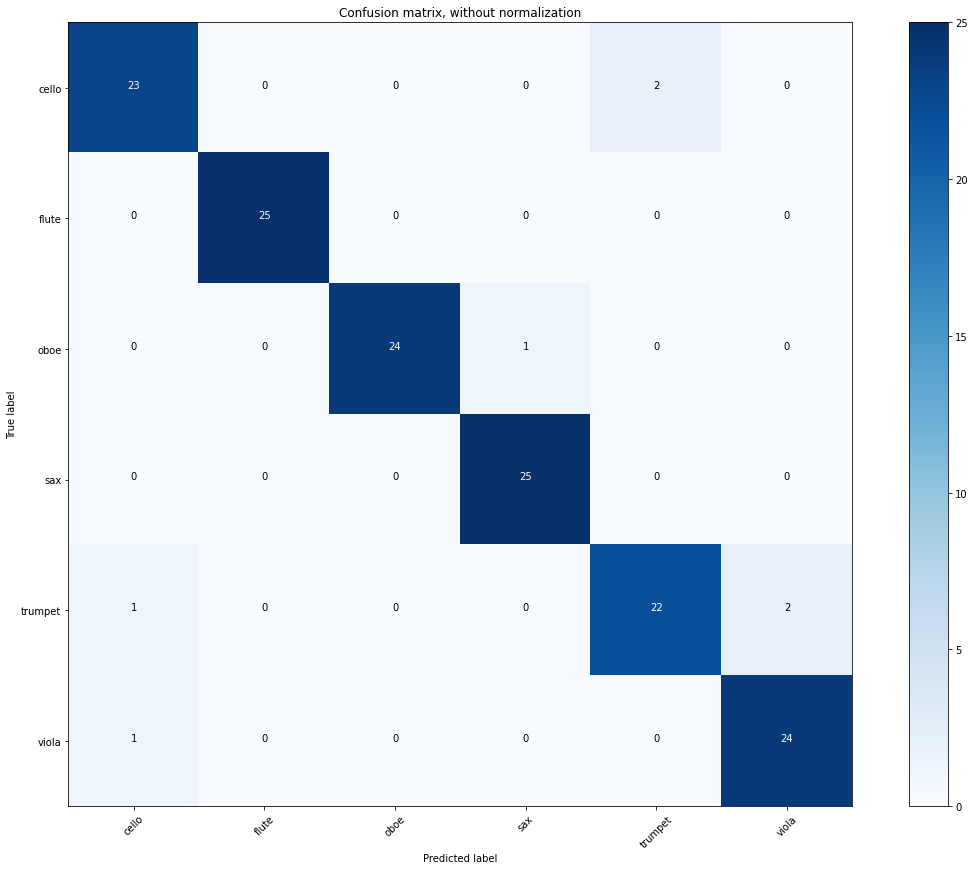

In [0]:
# Plot non-normalized confusion matrix
plt.figure(figsize=(16,12))
plot_confusion_matrix(cnf_matrix, classes=labelencoder.classes_,
                      title='Confusion matrix, without normalization')